In [9]:
!pip install Keras
import time
import numpy as np
import pandas as pd
#import dill as pkl
import pickle as pkl
from matplotlib import pyplot as plt
from collections import defaultdict
import nltk
import re
import itertools
import unittest
import RegexTester
from nltk.stem import WordNetLemmatizer
import nltk
from nltk.corpus import wordnet
%matplotlib inline
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.optimizers import SGD

from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, LSTM, GRU, Bidirectional, TimeDistributed
from keras.models import Model, load_model, Sequential
from keras import backend as K
from keras.engine.topology import Layer, InputSpec
from keras import initializers, regularizers, optimizers
from keras.callbacks import History, CSVLogger
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve, average_precision_score

You are using pip version 18.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


# Load Word Embeddings

In [33]:
def loadEmbed(file):
    start = time.time()
    print("Loading Embeddings")
    f = open(file, 'r', encoding='utf-8')
    model = {}
    status_every = 100000
    for i, line in enumerate(f):
        if i%status_every == 0:
            print('Processing line {:,}'.format(i))
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print("Done.",'{:,}'.format(len(model))," words loaded!")
    end = time.time()
    print("Total Time to load embeddings:", end - start, "seconds")
    return model

In [34]:
#TOO LARGE TO PUSH TO GIT, DOWNLOAD SEPARATLEY FROM https://github.com/stanfordnlp/GloVe
glove_dir = './glove.6B/'
glove_filename = 'glove.6B.300d.txt'
glove_fullpath = glove_dir + glove_filename
glove_dd = loadEmbed(glove_fullpath)

Loading Embeddings
Processing line 0
Processing line 100,000
Processing line 200,000
Processing line 300,000
Processing line 400,000
Done. 400,001  words loaded!
Total Time to load embeddings: 41.595529079437256 seconds


# BINARIZE LABELS

In [35]:
full_data = pkl.load(open("full_data_w_flattened_plots.pkl", 'rb'))

In [36]:
from sklearn.preprocessing import MultiLabelBinarizer

In [37]:
mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(full_data["list_genres"])
full_data["binarized_labels"] = y_train.tolist()

In [38]:
mlb.classes_

array(['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Music',
       'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Sport', 'Thriller',
       'War', 'Western'], dtype=object)

# TRAIN/TEST SPLIT

# Read Full Data and Generate Embeddings for BOW

In [39]:
full_data["plot_lengths"] = full_data["flattened_tokens"].apply(lambda row: len(row))

61.0


(array([7.0940e+03, 1.0725e+05, 7.3764e+04, 4.0858e+04, 1.9968e+04,
        6.4460e+03, 3.8200e+02, 4.9000e+01, 3.4000e+01, 8.0000e+00]),
 array([  4. ,  22.4,  40.8,  59.2,  77.6,  96. , 114.4, 132.8, 151.2,
        169.6, 188. ]),
 <a list of 10 Patch objects>)

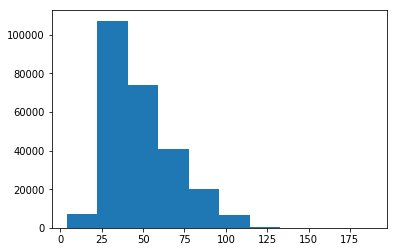

In [41]:
print(np.percentile(full_data["plot_lengths"],75))
plt.hist(full_data["plot_lengths"])

In [126]:
def embed_plot_BOW(plot):
    word_embeddings = np.array([glove_dd.get(word, glove_dd.get("unk")) for word in plot]).astype(np.float32)
    sentence_embedding = [sum(dim) for dim in zip(*word_embeddings)]
    return np.array(sentence_embedding)

In [128]:
print("Embedding plots...")
start = time.time()
full_data["flattened_embeddings"] = full_data["flattened_tokens"].apply(lambda row: embed_plot_BOW(row))
end = time.time()
print("Total Time to embed plots:", end - start, "seconds")

Embedding plots...
Total Time to embed plots: 813.7513613700867 seconds


In [129]:
full_data.to_pickle("./full_data_w_flattened_embeddings.pkl")

In [42]:
full_data = pd.read_pickle("./full_data_w_flattened_embeddings.pkl")

In [43]:
full_data_sample = full_data.iloc[0:2] #sample to start with

,genres,plots,list_genres,tokenized_words,flattened_tokens,binarized_labels,flattened_embeddings
0,Comedy,A stranded theatrical troupe manages to get ba...,[Comedy],"[[stranded, theatrical, troupe, manages, get, ...","[stranded, theatrical, troupe, manages, get, b...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-5.77803019399289, 0.6781772070680745, -5.014..."
1,Drama,While waiting at the bus stop for the woman he...,[Drama],"[[wait, bus, stop, woman, intend, marry, jay, ...","[wait, bus, stop, woman, intend, marry, jay, d...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-4.2481139693409204, 0.16822814429178834, -2...."


In [44]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(full_data["flattened_embeddings"], 
                                                    full_data["binarized_labels"], test_size=0.20, random_state=42)
#x_train = np.stack(full_data_sample["flattened_embeddings"].values)

In [58]:
X_train_sample = np.stack(X_train[0:100].values)
y_train_sample = np.stack(y_train[0:100].values)
X_test_sample = np.stack(X_test[0:100].values)
y_test_sample = np.stack(y_test[0:100].values)
X_train = np.stack(X_train.values)
y_train = np.stack(y_train.values)
X_test = np.stack(X_test.values)
y_test = np.stack(y_test.values)

# MODEL

In [126]:
model = Sequential()
model.add(Dense(100, input_shape=(X_train.shape[1],), activation='tanh'))
model.add(Dense(mlb.classes_.shape[0], activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ["accuracy"])
model.fit(X_train, y_train, epochs = 5, batch_size = 100)
preds = model.predict(X_test)

Epoch 1/5
204682/204682 [==============================] - 10s 51us/step - loss: 0.2123 - acc: 0.9197
Epoch 2/5
204682/204682 [==============================] - 7s 37us/step - loss: 0.1977 - acc: 0.9239
Epoch 3/5
204682/204682 [==============================] - 7s 35us/step - loss: 0.1957 - acc: 0.9245
Epoch 4/5
204682/204682 [==============================] - 7s 33us/step - loss: 0.1946 - acc: 0.9248
Epoch 5/5
204682/204682 [==============================] - 7s 34us/step - loss: 0.1938 - acc: 0.9251


# EVAL METRICS

In [127]:
def indiv_class_scores(y_true, y_pred, threshold, metric = None):
    y_pred = y_pred >= threshold
    for i in range(len(mlb.classes_)):
        if metric == "precision":
            score = precision_score(y_true[:,i], y_pred[:,i])
            print("The {} for {} is {}".format(metric, mlb.classes_[i], score))
        elif metric == "recall":
            score = recall_score(y_true[:,i], y_pred[:,i])
            print("The {} for {} is {}".format(metric, mlb.classes_[i], score))
        elif metric == "f1":
            score = f1_score(y_true[:,i], y_pred[:,i])
            print("The {} for {} is {}".format(metric, mlb.classes_[i], score))
        else:
            return "Not a valid metric"

In [128]:
indiv_class_scores(y_test, preds, threshold = 0.5, metric = "precision")

The precision for Action is 0.6199095022624435
The precision for Adventure is 0.5322164948453608
The precision for Animation is 0.6648976497346475
The precision for Biography is 0.6182795698924731
The precision for Comedy is 0.6740283537467451
The precision for Crime is 0.5676824946846208
The precision for Drama is 0.7033793388050805
The precision for Family is 0.6135105204872646
The precision for Fantasy is 0.6206896551724138
The precision for History is 0.6016528925619835
The precision for Horror is 0.7191780821917808
The precision for Music is 0.7645519947678221
The precision for Musical is 0.25
The precision for Mystery is 0.6024096385542169
The precision for Romance is 0.5337662337662338
The precision for Sci-Fi is 0.6857142857142857
The precision for Sport is 0.7339667458432304
The precision for Thriller is 0.5277227722772277
The precision for War is 0.6545667447306791
The precision for Western is 0.8225602027883396


In [129]:
indiv_class_scores(y_true, preds, threshold=0.5, metric = "recall")

The recall for Action is 0.24729241877256317
The recall for Adventure is 0.11637080867850098
The recall for Animation is 0.2785895806861499
The recall for Biography is 0.08556547619047619
The recall for Comedy is 0.48663138838601866
The recall for Crime is 0.21520687802256852
The recall for Drama is 0.6506892895015907
The recall for Family is 0.1350231537899098
The recall for Fantasy is 0.07154686982444518
The recall for History is 0.14595028067361668
The recall for Horror is 0.270548827621747
The recall for Music is 0.46278701504354713
The recall for Musical is 0.0018148820326678765
The recall for Mystery is 0.01771793054571226
The recall for Romance is 0.07323592302209551
The recall for Sci-Fi is 0.3747338537970192
The recall for Sport is 0.5250637213254036
The recall for Thriller is 0.09385455185772143
The recall for War is 0.374916163648558
The recall for Western is 0.5481418918918919


In [130]:
indiv_class_scores(y_true, preds, threshold= 0.5, metric= "f1")

The f1 for Action is 0.3535483870967742
The f1 for Adventure is 0.19098265895953756
The f1 for Animation is 0.392657264383255
The f1 for Biography is 0.1503267973856209
The f1 for Comedy is 0.5652015688811612
The f1 for Crime is 0.31209818819403856
The f1 for Drama is 0.6760091662259827
The f1 for Family is 0.22133439872153413
The f1 for Fantasy is 0.1283041283041283
The f1 for History is 0.23491448854469182
The f1 for Horror is 0.3931847968545216
The f1 for Music is 0.5765721331689273
The f1 for Musical is 0.0036036036036036032
The f1 for Mystery is 0.03442340791738382
The f1 for Romance is 0.1287997492948919
The f1 for Sci-Fi is 0.48462597521798995
The f1 for Sport is 0.6121842496285289
The f1 for Thriller is 0.15936612348632082
The f1 for War is 0.47675906183368866
The f1 for Western is 0.6578813988849468


In [131]:
y_pred = preds >= 0.5
micro_precision = precision_score(y_true, y_pred, average = 'micro')
weighted_macro_precision = precision_score(y_true, y_pred, average = 'weighted')
micro_recall = recall_score(y_true, y_pred, average = 'micro')
weighted_macro_recall = recall_score(y_true, y_pred, average = 'weighted')
micro_f1 = f1_score(y_true, y_pred, average = 'micro')
weighted_macro_f1 = f1_score(y_true, y_pred, average = 'weighted')



In [132]:
print("The micro precision is", micro_precision)
print("The weighted macro precision is", weighted_macro_precision)
print("The micro recall is", micro_recall)
print("The weighted macro recall is", weighted_macro_recall)
print("The micro f1 is", micro_f1)
print("The weighted macro f1 is", weighted_macro_f1)

The micro precision is 0.6787603000860902
The weighted macro precision is 0.6433844455202036
The micro recall is 0.3525091017479614
The weighted macro recall is 0.3525091017479614
The micro f1 is 0.4640284745382697
The weighted macro f1 is 0.4201221196072813


In [147]:
full_data["tokenized_words"].iloc[2]

[['dissatisfied', 'ranch', 'hand', 'become', 'bounty', 'hunter', '.'],
 ['conspires',
  'crook',
  'town',
  'bos',
  'dirty',
  'neighboring',
  'village',
  'valuable',
  'railroad',
  'franchise',
  'head',
  'order',
  'divert',
  'town',
  'bos',
  'own',
  '.'],
 ['find',
  'former',
  'fiancée',
  'marry',
  'sheriff',
  'town',
  'seek',
  'destroy',
  '.']]